In [ ]:
import os

import logging
import sys
from llama_index.llms.openai import OpenAI
from llama_index.core import Settings
import matplotlib.pyplot as plt
import json
import numpy as np

logging.basicConfig(stream=sys.stdout, level=logging.INFO)

# define LLM
llm = OpenAI(temperature=0, model="gpt-3.5-turbo")
Settings.llm = llm
Settings.chunk_size = 512
from llama_index.core import KnowledgeGraphIndex, Document
from llama_index.core import StorageContext
from llama_index.graph_stores.neo4j import Neo4jGraphStore

import chromadb
from llama_index.vector_stores.chroma import ChromaVectorStore



from llama_index.llms.openai import OpenAI
import json

from dataclasses import dataclass
from typing import List, Dict
import tqdm

import random

from utils import deserialize_wikipedia_embeddings, serialize_wikipedia_embeddings

In [2]:
#%load_ext autoreload
#%autoreload 2

In [3]:
username = "neo4j"
password = "password"
url = "bolt://35.229.117.88:7687"
database = "wikipedia"

In [4]:
@dataclass
class BeerQAEntry:
    id: str
    src: str
    answers: List[str]
    question: str
    context: Dict[str, str]

In [5]:
with open("beerqa_subset.json") as f:
    beerqa_subset = json.load(f)
    beerqa_subset = [BeerQAEntry(**b) for b in beerqa_subset]

In [6]:
beerqa_keys = set()
for entry in beerqa_subset:
    beerqa_keys.update(entry.context.keys())

In [7]:
len(beerqa_keys)

784

In [8]:
# initialize client, setting path to save data
db = chromadb.PersistentClient(path="./chroma_db")

# create collection
chroma_collection = db.get_or_create_collection("wikipedia")

# assign chroma as the vector_store to the context
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)

INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


In [9]:
graph_store = Neo4jGraphStore(
    username=username,
    password=password,
    url=url,
    database=database,
)


storage_context = StorageContext.from_defaults(graph_store=graph_store)

# NOTE: can take a while!

In [10]:
beerqa_sample = list(beerqa_keys)

In [11]:
docs = {}

for question in tqdm.tqdm(beerqa_subset):
    for k, context in question.context.items():
        docs[k] = context

documents = [Document(text=val) for val in docs.values()]



100%|██████████| 400/400 [00:00<00:00, 873813.33it/s]


In [12]:

graph_store = Neo4jGraphStore(
    username=username,
    password=password,
    url=url,
    database=database,
)
index = KnowledgeGraphIndex(
    [],
    storage_context=StorageContext.from_defaults(graph_store=graph_store),
)
index.index_struct.embedding_dict = deserialize_wikipedia_embeddings()
#with open('wikipedia_embeddings.json', 'r') as f:
#    index.index_struct.embedding_dict = json.load(f)

In [13]:
from utils import deserialize_wikipedia_embeddings, serialize_wikipedia_embeddings

In [14]:
from llama_index.core.indices import VectorStoreIndex
from llama_index.vector_stores.chroma import ChromaVectorStore

In [15]:
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

In [16]:
doc_index = VectorStoreIndex(documents, storage_context=storage_context, show_progress=True)

/var/home/zaristei/.conda/envs/rag-project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating embeddings:   0%|          | 0/784 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Generating embeddings:  13%|█▎        | 100/784 [00:00<00:05, 125.48it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Generating embeddings:  26%|██▌       | 200/784 [00:02<00:07, 77.95it/s] 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Generating embeddings:  38%|███▊      | 300/784 [00:03<00:04, 99.55it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Generating embeddings:  51%|█████     | 400/784 [00:03<00:03, 115.98it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Generating embeddings:  64%|██████▍   | 500/784 [00:04<00:02, 138.73it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Generating embeddings:  77%|███████▋  | 600/784 [00:09<00:03, 47.09it/s] 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Generating embeddings:  89%|████████▉ | 700/784 [00:09<00:01, 58.71it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Generating embeddings: 100%|██████████| 784/784 [00:10<00:00, 73.85it/s]


In [17]:
from query_engine import SemanticCachedStringQueryEngine, RAGCachedStringQueryEngine

INFO:faiss.loader:Loading faiss with AVX2 support.
INFO:faiss.loader:Successfully loaded faiss with AVX2 support.


In [27]:
def run_query(dataset, threshold=0.5):
    if threshold is None:
        engine = RAGCachedStringQueryEngine(llm, index, doc_index, traverse_k=3, retrieve_k=5, return_n=5)
        engine.reset_info()
    else:
        engine = SemanticCachedStringQueryEngine(llm, index, doc_index, traverse_k=3, retrieve_k=5, return_n=5, threshold=threshold)
    results = []
    for i in dataset:
        results.append(engine.custom_query(i.question))
    engine.serialize_time_profile()
    return results

In [28]:
threshs = [None, 1, 1.3, 1.6, 1.9, 2]
results = []
for t in tqdm.tqdm(threshs):
    results.append(run_query(beerqa_subset[:100], threshold=t))

  0%|          | 0/6 [00:00<?, ?it/s]

Cache size set to:  0
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200

 17%|█▋        | 1/6 [04:01<20:09, 241.82s/it]

Index trained
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-mpnet-base-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda


Batches: 100%|██████████| 1/1 [00:00<00:00, 150.28it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 169.18it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 90.89it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 129.39it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 224.20it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 178.87it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 99.81it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 124.66it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 223.24it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 215.45it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 181.98it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 52.26it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 69.60it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 153.12it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 141.51it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 136.28it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 151.92it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 92.45it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 62.72it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 208.65it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 48.89it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 89.04it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 206.48it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 76.49it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 218.39it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 51.20it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 90.48it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 217.46it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 175.23it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 202.88it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 237.91it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 126.15it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 60.51it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 241.54it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 200.52it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 199.15it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 156.83it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 209.28it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 95.64it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 206.97it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 232.08it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 164.61it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 225.84it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 204.14it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 203.67it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 187.98it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 202.31it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 232.41it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 167.99it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 68.58it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 55.69it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 151.33it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 181.12it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 208.29it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 149.98it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 163.64it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 107.05it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 197.70it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 82.20it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 208.69it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 236.94it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 218.27it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 236.95it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 213.89it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 182.14it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 71.06it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 204.35it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 99.38it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 106.26it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 210.28it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 234.65it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 216.12it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 209.52it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 226.16it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 214.61it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 175.45it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 216.77it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 82.32it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 143.77it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 186.43it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 192.51it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 146.29it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 145.50it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 209.56it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 95.30it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 100.87it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 131.17it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 44.41it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 146.20it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 192.06it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 219.93it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 200.10it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 56.19it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 207.60it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 199.69it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 194.72it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 130.21it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 231.32it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 119.26it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 33%|███▎      | 2/6 [08:08<16:19, 244.81s/it]

Index trained
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-mpnet-base-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda


Batches: 100%|██████████| 1/1 [00:00<00:00, 207.05it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 137.69it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 137.60it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 223.71it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 58.36it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 183.40it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 210.77it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 106.69it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 88.00it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 188.08it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 143.54it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 200.38it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 211.03it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 196.21it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 97.82it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 79.43it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 168.47it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 237.03it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 232.56it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 77.08it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 149.76it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 219.37it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 150.75it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 75.89it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 128.93it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 188.70it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 154.54it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 173.70it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 129.36it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 58.50it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 192.67it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 210.25it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 120.05it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 110.19it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 210.29it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 78.91it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 189.63it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 218.49it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 134.68it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 206.14it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 210.01it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 45.26it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 129.34it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 133.02it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 130.57it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 195.62it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 194.11it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 207.81it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 74.32it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 81.04it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 156.05it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 113.75it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 111.30it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 158.98it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 108.91it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 96.97it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 192.39it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 214.87it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 142.56it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 73.98it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 221.14it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 202.03it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 173.23it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 186.98it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 220.00it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 222.33it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 198.78it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 134.29it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 85.35it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 209.27it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 111.91it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 85.59it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 203.93it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 71.99it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 93.88it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 207.82it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 203.36it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 194.08it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 146.14it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 101.23it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 114.10it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 229.80it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 203.51it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 225.40it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 191.57it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 118.16it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 177.80it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 220.96it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 203.62it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 198.27it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 90.12it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 116.52it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 210.96it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 204.19it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 195.35it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 188.94it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 209.62it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 238.61it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 73.83it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 190.31it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 50%|█████     | 3/6 [11:03<10:38, 212.75s/it]

Index trained
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-mpnet-base-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda


Batches: 100%|██████████| 1/1 [00:00<00:00, 209.38it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 195.78it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 215.87it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 44.50it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 117.89it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 156.06it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 209.96it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 106.04it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 147.58it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 137.56it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 221.04it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 45.92it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 195.85it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 167.90it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 108.24it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 217.70it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 212.90it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 192.06it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 119.18it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 214.97it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 88.67it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 164.15it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 233.47it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 150.89it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 74.55it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 52.97it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 91.61it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 194.32it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 190.68it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 122.40it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 116.78it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 137.07it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 217.01it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 214.63it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 201.76it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 172.81it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 225.23it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 177.72it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 219.67it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 85.58it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 162.24it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 212.28it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 166.61it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 117.57it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 208.97it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 217.61it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 229.47it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 229.42it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 141.70it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 158.26it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 211.66it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 206.80it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 220.65it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 207.01it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 197.71it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 100.72it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 213.67it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 223.53it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 193.13it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 118.55it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 165.60it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 193.99it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 207.44it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 67.38it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 220.31it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 45.17it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 88.86it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 106.99it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 235.11it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 228.77it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 145.72it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 164.42it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 176.80it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 156.20it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 182.71it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 148.29it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 207.59it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 132.28it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 178.94it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 200.79it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 199.89it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 63.88it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 35.36it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 166.58it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 110.78it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 174.67it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 204.66it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 191.50it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 176.95it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 219.28it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 210.22it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 222.17it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 199.13it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 239.83it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 196.65it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 184.00it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 203.59it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 157.28it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 216.67it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 150.39it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 67%|██████▋   | 4/6 [12:51<05:42, 171.40s/it]

Index trained
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-mpnet-base-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda


Batches: 100%|██████████| 1/1 [00:00<00:00, 206.64it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 213.68it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 212.38it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 219.15it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 128.43it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 95.55it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 90.81it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 66.85it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 128.32it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 211.32it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 195.57it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 159.32it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 172.43it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 108.40it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 123.89it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 115.85it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 199.42it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 189.53it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 224.11it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 209.52it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 151.23it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 158.29it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 106.95it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 134.84it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 130.04it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 107.43it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 144.75it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 179.81it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 186.10it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 106.09it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 208.78it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 200.92it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 195.42it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 219.17it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 204.69it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 75.88it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 165.73it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 171.29it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 184.93it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 210.05it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 103.79it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 127.91it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 110.71it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 226.02it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 106.36it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 109.69it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 197.48it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 80.60it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 181.32it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 210.40it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 201.38it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 220.73it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 216.66it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 215.08it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 95.10it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 198.62it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 109.93it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 118.68it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 76.07it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 237.53it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 188.41it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 220.56it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 241.11it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 174.07it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 183.37it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 234.34it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 67.83it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 239.80it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 208.85it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 95.98it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 46.56it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 211.45it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 54.68it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 186.31it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 117.54it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 225.57it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 227.63it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 194.13it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 214.82it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 102.51it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 152.11it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 129.91it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 190.67it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 209.25it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 83.01it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 119.05it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 119.19it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 106.79it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 204.54it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 210.22it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 146.05it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 171.04it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 218.69it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 102.30it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 245.14it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 199.07it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 207.42it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 178.69it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 112.04it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 202.29it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 83%|████████▎ | 5/6 [14:08<02:17, 137.50s/it]

Index trained
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-mpnet-base-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda


Batches: 100%|██████████| 1/1 [00:00<00:00, 194.32it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 213.66it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 207.26it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 207.44it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 232.64it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 201.03it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 188.36it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 142.98it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 231.07it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 237.62it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 179.57it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 208.30it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 73.26it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 96.57it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 215.38it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 192.87it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 186.12it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 223.48it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 213.10it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 247.69it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 232.15it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 243.39it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 228.96it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 236.47it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 204.80it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 71.70it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 97.88it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 231.24it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 234.28it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 185.61it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 235.25it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 234.24it/s]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 205.22it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 198.10it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 203.31it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 216.66it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 208.13it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 167.39it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 208.26it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 100.24it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 217.42it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 110.08it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 235.19it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 205.05it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 222.11it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 219.56it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 233.17it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 110.66it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 103.91it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 81.17it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 62.66it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 235.90it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 176.74it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 120.37it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 77.33it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 122.87it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 149.43it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 223.16it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 173.60it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 207.80it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 225.28it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 214.91it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 210.00it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 222.72it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 146.77it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 185.03it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 191.93it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 140.71it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 209.83it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 206.63it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 210.68it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 181.32it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 196.92it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 230.37it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 215.57it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 100.67it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 212.68it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 158.43it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 173.83it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 211.88it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 214.85it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 215.90it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 178.31it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 237.54it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 208.75it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 86.43it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 202.88it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 174.49it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 211.96it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 72.50it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 111.21it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 192.66it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 118.25it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 54.41it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 214.43it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 218.51it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 200.51it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 205.15it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 130.18it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00, 201.55it/s]

Cache Hit!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


100%|██████████| 6/6 [15:09<00:00, 151.60s/it]


In [43]:
thresholds = [None, 1, 1.3, 1.6, 1.9, 2]

time_profile = [[], [], [], [], [], [], []]

for t in thresholds:
    if t is None:
        file_path = "data/cache_wikipedia_traverse_k=3_retrieve_k=5_return_n=5_cache_size=0_time_profile.json"
    else:
        file_path = f"data/semantic_cache_wikipedia_traverse_k=3_retrieve_k=5_return_n=5_threshold={t}_time_profile.json"
    with open(file_path, 'r') as file:
        data = json.load(file)
        temp = {"NODE RETRIEVAL": 0.0, "NODE TRAVERSAL": 0.0, "DOCUMENT RETRIEVAL": 0.0, "NUM TOTAL DOCUMENTS": 0.0, "SEMANTIC CACHE HITS": 0}
        for i in range(len(data)):
            # print(data[i])
            temp["NODE RETRIEVAL"] += data[i]["NODE RETRIEVAL"]
            temp["DOCUMENT RETRIEVAL"] += data[i]["DOCUMENT RETRIEVAL"]
            temp["NODE TRAVERSAL"] += data[i]["NODE TRAVERSAL"]
            temp["NUM TOTAL DOCUMENTS"] += data[i]["NUM TOTAL DOCUMENTS"]
            if t is None:
                temp["SEMANTIC CACHE HITS"] = 0
            else:
                temp["SEMANTIC CACHE HITS"] = data[i]["SEMANTIC CACHE HITS"]

        temp["NODE RETRIEVAL"] = temp["NODE RETRIEVAL"] / len(data)
        time_profile[0].append(temp["NODE RETRIEVAL"] / len(data))

        temp["DOCUMENT RETRIEVAL"] = temp["DOCUMENT RETRIEVAL"] / len(data)
        time_profile[1].append(temp["DOCUMENT RETRIEVAL"] / len(data))

        temp["NODE TRAVERSAL"] = temp["NODE TRAVERSAL"] / len(data)
        time_profile[2].append(temp["NODE TRAVERSAL"] / len(data))

        temp["NUM TOTAL DOCUMENTS"] = temp["NUM TOTAL DOCUMENTS"] / len(data)
        time_profile[3].append(temp["NUM TOTAL DOCUMENTS"] / len(data))

        time_profile[4].append(temp["SEMANTIC CACHE HITS"])
        print(file_path)
        # time_profile.append(temp)

print(time_profile)

data/cache_wikipedia_traverse_k=3_retrieve_k=5_return_n=5_cache_size=0_time_profile.json
data/semantic_cache_wikipedia_traverse_k=3_retrieve_k=5_return_n=5_threshold=1_time_profile.json
data/semantic_cache_wikipedia_traverse_k=3_retrieve_k=5_return_n=5_threshold=1.3_time_profile.json
data/semantic_cache_wikipedia_traverse_k=3_retrieve_k=5_return_n=5_threshold=1.6_time_profile.json
data/semantic_cache_wikipedia_traverse_k=3_retrieve_k=5_return_n=5_threshold=1.9_time_profile.json
data/semantic_cache_wikipedia_traverse_k=3_retrieve_k=5_return_n=5_threshold=2_time_profile.json
[[0.015358660221099853, 0.013751313257217408, 0.008715162467956544, 0.0035519301414489745, 0.0011261161565780638, 0.0003263399124145508], [0.0018509788751602174, 0.0031555943250656127, 0.001916246509552002, 0.000976987600326538, 0.0002471041202545166, 3.046832084655762e-05], [0.001158142328262329, 0.0015606435537338257, 0.0009175498962402344, 0.0003709264755249023, 9.514706134796142e-05, 2.8909206390380857e-05], [0.1

In [44]:
thresholds

[None, 1, 1.3, 1.6, 1.9, 2]

In [45]:
threshold_labels = thresholds.copy()
threshold_labels[0] = "Redis"

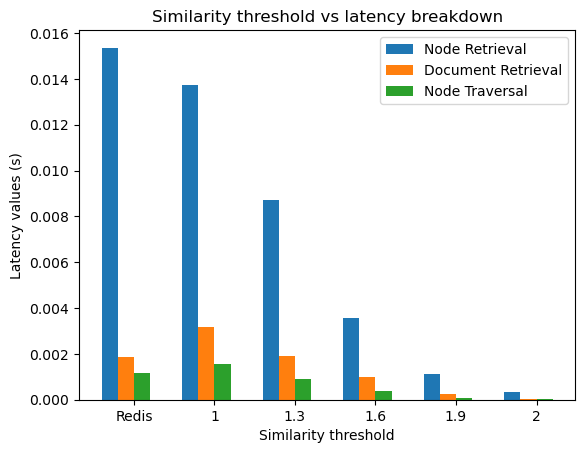

In [46]:
bar_width = 0.2

# Set the x locations for the groups
x = np.arange(len(thresholds))

# Create multi-bar chart
plt.bar(x - 1.5 * bar_width, time_profile[0], width=bar_width, label='Node Retrieval')
plt.bar(x - 0.5 * bar_width, time_profile[1], width=bar_width, label='Document Retrieval')
plt.bar(x + 0.5 * bar_width, time_profile[2], width=bar_width, label='Node Traversal')
#plt.bar(x + 1.5 * bar_width, time_profile[3], width=bar_width, label='Group 4')

# Add labels and title
plt.xlabel('Similarity threshold')
plt.ylabel('Latency values (s)')
plt.title('Similarity threshold vs latency breakdown')
plt.xticks(x, threshold_labels)
plt.legend()

# Show the plot
plt.show()

In [41]:
time_profile[4][0]

0

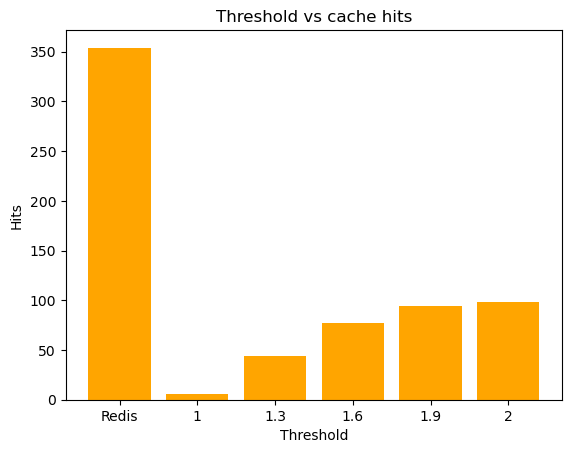

In [49]:
with open("data/cache_wikipedia_traverse_k=3_retrieve_k=5_return_n=5_cache_size=0_redis.json", 'r') as f:
    temp_dict = json.load(f)
time_profile[4][0] = temp_dict["keyspace_hits"]
plt.bar(x, time_profile[4], color="orange")

# Add labels and title
plt.xlabel('Threshold')
plt.ylabel('Hits')
plt.title('Threshold vs cache hits')
plt.xticks(x, threshold_labels)

# Show the plot
plt.show()

In [50]:
def is_correct(result, ground_truth):
    for ans in ground_truth.answers:
        if ans not in result.response:
            return False
    return True

def calculate_accuracy(results, dataset):
    correct = 0
    for result, ground_truth in zip(results, dataset):
        if is_correct(result, ground_truth):
            correct += 1
    return correct / len(results)

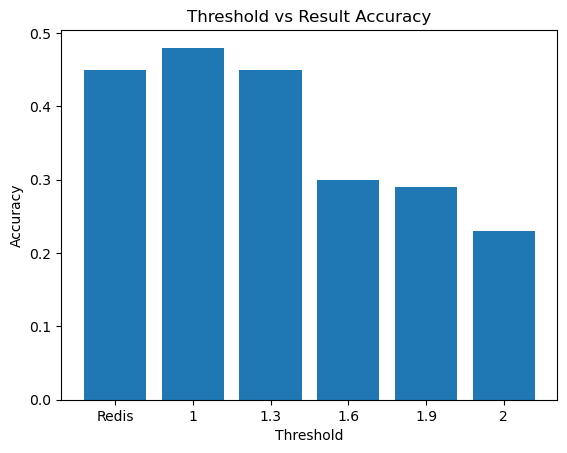

In [51]:
accs = []
for r in results:
    accs.append(calculate_accuracy(r, beerqa_subset[:100]))
    
plt.bar(x, accs)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Threshold vs Result Accuracy')
plt.xticks(x, threshold_labels)
plt.show()

In [52]:
accs

[0.45, 0.48, 0.45, 0.3, 0.29, 0.23]